# CFEP1

The free energy profile and diffusion coefficient, $F(r)$ and $D(r)$, completely specify a diffusive model of the dynamics projected on reaction coordinate r. Here we show how they, or rather the related cut profiles, $Z_{C,1}$ and $Z_H$, can be used to compute various properties of dynamics, e.g., the equilibrium flux, the mean first passage times, and the mean transition path times. We will compute and compare these properties computed from the profiles and directly from trajectories.

Generally, the properties computed from the profiles and directly from the trajectories should be in agreement. However, in principle, the following sources of error, which lead to difference between them are possible:

 - the employed reaction coordinate is not good or not optimal. So the diffusive model of the dynamics is not a good model of the actual dynamics projected on the coordinates, e.g., the later is subdiffusive and non-markovian. We consider later how the profiles can be used to check if the employed reaction coordinate is optimal, e.g., to validate the reaction coordinate.
 - the sampling interval of the trajectory $\Delta t$ is rather large, so that the simple relations between the profiles and the $F(r)$ and $D(r)$ are not accurate anymore.
 - the sampling interval of the trajectory $\Delta t$ is rather large, so that the quantities estimated directly from trajectory sampled with a finite $\Delta t$ are different from that estimated with infinitesimally small $\Delta t$, corresponding to the analytical estimates of the diffusion models. For example, in estimating the number of transition between two boundary states, the system may shortly visit a boundary state then quickly come back. Some of such events can be missed if observed/recorded with a relatively large $\Delta t$.

If the reaction coordinate is good and the diffusive model provide an accurate description of the dynamics, and non of the above errors apply, we can expect to estimate accurately various dynamics/kinetics properties. For example, the diffusive model along the committor coordinate can be used to compute the following properties exactly: the equilibrium flux, the mean first passage times, and the mean transition path times between any two points (A and B) along the committor.

To define these properties, consider a very long equilibrium trajectory on a configuration space, where two boundary states A and B are defined. The trajectory will visit repeatedly these states, which we represent symbolically as A -> B -> A -> B ... Note that, after visiting state A, the system may visit state A many times, before visiting state B, such repeated visits are discarded. Only first visits A after B and B after A are considered. The equilibrium flux is the number of transitions from A to B or from B to A per unit time, i.e., $N_{AB}/T=N_{BA}/T$, where T is the trajectory length. The mean first passage time, e.g, from A to B,  is the average time required by system to reach B starting from A. A good example, is the mean folding time - the time required for a protein to fold. It can be computed by considering all those segments of trajectories, from the first visit of A till the first visit of B. The total time of such segments should be divided by the total number of such segments $N_{AB}$. The mean transition-path time measures the actual time system takes to go from, say A to B.  It discards all the repeated visits to the same state, i.e, A->A, and considers segments of trajectory from the last visit to A to the first visit of B. The mean time is defined analogously as the total time of such segments should be divided by the total number of such segments $N_{AB}$. In the protein folding, the mean folding time strongly (exponentially) depends on the folding barrier, and varies significantly, depending on the protein. The mean transition-path time, which is much shorter than folding time, on the contrary depends on the barrier height only weakly.

Below we consider how to compute these properties using the profiles, and how one can test for the second and third error. As, mentioned above, we discuss the first error later. Here we consider a one-dimensional trajectory of one-dimensional diffusion, i.e., the coordinate is optimal and the first error does not exist.

We start with a diffusive motion between two minima with potential $U(x)=1/2 \cos(x)$; steep potential is imposed outside of the allowed region of $-2<x<2$. We import function from the cfep library to run the diffusion and compute the profiles.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="The raw code for this Python notebook is by default hidden for easier reading. Click here to toggle on/off the raw code."></form>''')

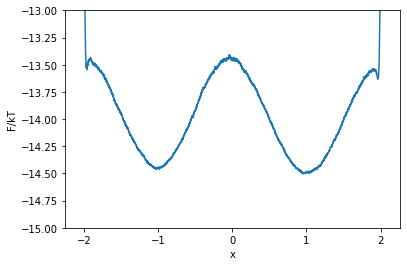

In [2]:
# Import functions
from math import sin,cos,pi,log
from cfeplib import comp_diffusion_euler, comp_Zca
import numpy as np

# specify the drift and diffusion coefficient
def f(x):
    if abs(x)<2:return sin(x*pi)*pi*0.5
    return -x*100
def D(x):
    return 1

# run diffusion and compute the profile
dt=0.001
np.random.seed(0)
traj=comp_diffusion_euler(f,D,dt,10000000)
lx,ly=comp_Zca(traj,a=-1,dx=0.001)
ly=[-log(y) for y in ly]

# plot the profile
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(lx,ly)
plt.ylim(-15,-13)
plt.ylabel('F/kT')
_=plt.xlabel('x')

The free energy profile $F/kT(x)$ computed from the MC trajectory reproduces $U(x)$ with good accuracy.


We start with the equilibrium flux between two states A and B, which is defined as $J_{AB}=N_{AB}/N\Delta t_0$, here $N_{AB}$ is the number of transitions made by the trajectory from node A to node B, $N_{AB}=N_{BA}$, and $N\Delta t_0$ it the total time length of the trajectory. $N_{AB}$ can be computed as 
$\frac{1}{N_{AB}}=\int_{r(A)}^{r(B)} \frac{dr}{Z_{C,1}(r)}$ [2,3]. 

We will use two functions, first - to compute $N_{AB}$ from a MC trajectory and second - to compute $N_{AB}$ using the diffusive model.

In [3]:
def Nab_traj(traj,a,b):
    il=None
    n=0
    for x in traj:
        ic=None
        if x<a: ic=1
        if x>b: ic=2
        if ic!=None and il!=None and ic!=il: n+=1
        if ic!=None: il=ic
    return n/2.
        
def Nab_model(lx,lzc1,a,b):
    lx1=[lx[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    ly1=[1/lzc1[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    
    from scipy.integrate import simps
    I=simps(ly1,lx1)
    return 1./I

a=-1
b=1
lx1,ly1=comp_Zca(traj,a=1,dx=0.0001)
print ('Nab_traj:',Nab_traj(traj,a,b),', Nab_model:',Nab_model(lx1,ly1,a,b))

Nab_traj: 1016.0 , Nab_model: 1089.7936618061924


As one can see the numbers are in good agreement, the difference is about a few %.

To see the contribution of each error in the estimates, we recompute them for increasing sampling intervals $\Delta t$. For that we resample the original trajectory:

In [4]:
print ('dt, Nab_traj, Nab_model')
for dt in range(1,11):
    traj1=[traj[i] for i in range(1,len(traj),dt)]
    lx1,ly1=comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))    

dt, Nab_traj, Nab_model
1 1016.0 1089.792809223691
2 1012.0 1090.4450954999725
3 1006.0 1092.9196850624196
4 1006.0 1091.8507154146928
5 996.0 1092.6807762227281
6 998.0 1093.5877329203254
7 992.0 1094.748728904504
8 987.0 1090.7433308044374
9 986.0 1096.8710528632998
10 980.0 1095.9184980979926


$N_{AB}$ computed with the diffusion model fluctuate by less than 1 % when $\Delta t$ is increased $10$ times. $N_{AB}$ computed directly from trajectory decrease by about 3 %, showing that this error is much larger than the other and is dominant in explaining the difference between the estimates. The errors work in opposite direction: with increasing $\Delta t$ the diffusive model overestimates $N_{AB}$ while the direct counting underestimates it. One may expect that the error for direct counting will be especially large, when the boundaries of the regions are on the steep slopes of the landscape, so that the system has a high probability to come back the next step. However, for very small $\Delta t$, the deterministic drift contribution to the random dynamics is expected to be small.

We consider also the following boundary states 

$a,b=\pm 0.5$ 

In [5]:
a=-0.5
b=0.5

print ('dt, Nab_traj, Nab_model')
for dt in range(1,11):
    traj1=[traj[i] for i in range(1,len(traj),dt)]
    lx1,ly1=comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))    

dt, Nab_traj, Nab_model
1 1547.0 1662.9891386088955
2 1520.0 1664.3554644281253
3 1502.0 1671.3641259628741
4 1493.0 1671.2988932534256
5 1478.0 1672.9550193456703
6 1467.0 1676.1197402555174
7 1464.0 1678.5920090218353
8 1449.0 1672.700254540786
9 1438.0 1685.8504182495938
10 1439.0 1683.867219810434


and $a,b=\pm 1.5$.

In [6]:
a=-1.5
b=1.5

print ('dt, Nab_traj, Nab_model')
for dt in range(1,11):
    traj1=[traj[i] for i in range(1,len(traj),dt)]
    lx1,ly1=comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))    

dt, Nab_traj, Nab_model
1 786.0 813.987928499997
2 779.0 813.7717058561433
3 782.0 814.8136415595451
4 773.0 813.8470214819878
5 777.0 813.6753209561978
6 767.0 814.0630328309164
7 765.0 815.096848034272
8 757.0 812.0937057371298
9 762.0 815.290824739784
10 759.0 814.4368111997991


In both cases the largest error seems to be in the direct counting from trajectory. 

Next we compute the mean first passage time (mfpt) and the mean transition path times (mtpt). The mfpt is the mean time of trajectory to reach one boundary starting from another boundary. We will use the following equation
$$\mathrm{mfpt}_{AB}= \frac{N\Delta t}{N_{AB}}\int dq P_{eq}(q) (1-q)=\langle 1-q \rangle / J_{AB},$$ here $q(x)=q_{AB}(x)$ is the committor function to go from A to B [2,3]. The interpretation of the equation is that the mfpt equals time spent by the system in the mfpt ensemble divided by the total number of transitions. The mfpt ensemble AB consists of those segments of trajectory that start in state A and ends in state B, with stationary distribution $P_{AB}=P_{eq}(x)(1-q_{AB}(x))$. Combining with the mfpt ensemble BA (for which $q_{BA}=1-q_{AB}$) one obtains $\mathrm{mfpt}_{AB}+\mathrm{mfpt}_{BA}=<1-q>/J_{AB}+<q>/J_{AB}=1/J_{AB}$, the reciprocal of the equilibrium flux - the mean time per transition.

The committor function can be computed as [1] $$q_{AB}(x)=\frac{\int_A^x dr /Z_{C,1}(r)}{\int_A^B dr /Z_{C,1}(r)}.$$ 

Analogously, for the mean transition path times (mtpt), the segments of trajectories starting and ending at the opposite boundaries,  one obtains [2,3]
$$\mathrm{mtpt}_{AB}= \frac{N\Delta t}{N_{AB}}\int dq P_{eq}(q) q(1-q)=\langle q(1-q) \rangle / J_{AB}.$$ We will employ single functions to compute all these properties.

In [7]:
def fab_model(traj,a,b,dx=0.0001):
    lx,lzc1=comp_Zca(traj,1,dx=dx)
    lx,lzh=comp_Zca(traj,-1,dx=dx)
    from scipy.integrate import cumtrapz,simps
    ly=[1/y for y in lzc1]
    lq=cumtrapz(ly,lx,initial=0)
    lqa=[(abs(x-a),i) for i,x in enumerate(lx)]
    lqa.sort()
    ia=lqa[0][-1]
    qa=lq[ia]
    lqb=[(abs(x-b),i) for i,x in enumerate(lx)]
    lqb.sort()
    ib=lqb[0][-1]
    qb=lq[ib]
    def qp(q,qa,qb):
        if q<qa: return 0
        if q>qb: return 1
        return (q-qa)/(qb-qa)
    lqp=[qp(q,qa,qb) for q in lq]
    lind=[1 if a<x and x<b else 0 for x in lx]
    nab=1/simps([ind/zc1 for ind,zc1 in zip(lind,lzc1)],lx)
    n=len(traj)
    ztot=simps(lzh,lx)
    mfptab=simps([zh*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mfptba=simps([zh*q for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mtpt=simps([zh*q*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    return nab,mfptab,mfptba,mtpt

def fab_traj(traj,a,b):
    il=None
    nab=0
    mfptab=0
    mfptba=0
    mtpt=0
    tp=0
    fp=0
    for i,x in enumerate(traj):
        if x<a: 
            ic=1
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptba=mfptba+i-fp
                fp=i
            il=ic
            tp=i
        if x>b: 
            ic=2
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptab=mfptab+i-fp
                fp=i
            il=ic
            tp=i
    return nab/2.,2.*mfptab/nab,2.*mfptba/nab,float(mtpt)/nab
    
a=-1
b=1  
print('traj:  NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_traj(traj,a,b))
print('model: NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_model(traj,a,b))    

traj:  NAB=1016, mfpt_AB=4757.14, mftp_BA=5083.87, mtpt=539.414
model: NAB=1089.76, mfpt_AB=4438.15, mftp_BA=4738.15, mtpt=507.745


The quantities are in rather good agreement with the difference in the range of a few %. Note, that the times here are given in units of $\Delta t$.

### References

[1] S. V. Krivov, On Reaction Coordinate Optimality, *Journal of Chemical Theory and Computation* 2013 **9** (1), 135-146 

[2] P. V. Banushkina, S. V. Krivov, Optimal Reaction Coordinates, *WIREs Comput. Mol. Sci.* 2016 **6**, 748-763

[3] S. V. Krivov, Protein Folding Free Energy Landscape along the Committor - the Optimal Folding Coordinate, *Journal of Chemical Theory and Computation* 2018 **14** (7), 3418-3427